<h2 id="t1" style="margin-bottom: 18px">Imbalanced datasets</h2>

This case study tries to handle highly unbalanced datasets, with a focus on resampling. 

In [58]:
import numpy as np
import pandas as pd

df_train = pd.read_csv('creditcard.csv')

df_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class 0: 284315
Class 1: 492
Proportion: 577.88 : 1


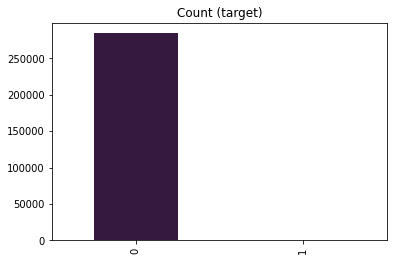

In [61]:
target_count = df_train.Class.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

<AxesSubplot:xlabel='0', ylabel='1'>

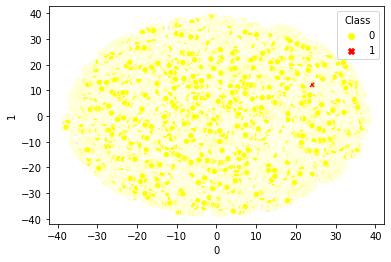

In [82]:
import seaborn as sns
from sklearn.manifold import TSNE
X = df_train.iloc[:,:-1]
y = df_train['Class']
X_embedded = TSNE(n_components=2).fit_transform(X)

tsne_df=pd.concat([pd.DataFrame(X_embedded),y], axis=1)

sns.scatterplot(x=0, y=1, hue="Class", style='Class', data = tsne_df, palette=['yellow','red'])

In [79]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


labels = df_train.columns

X = df_train.iloc[:,2:-1]
y = df_train['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X)

accuracy = accuracy_score(y, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:32:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 99.99%
Confusion matrix:
 [[284311      4]
 [    20    472]]


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


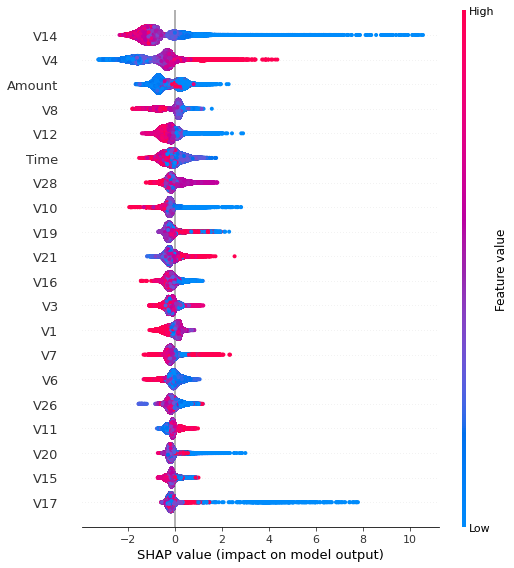

In [66]:
import shap
# make sure the SHAP values add up to marginal predictions
pred = model.predict(X)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [71]:
shap_values

array([[ 0.03211679, -0.05121954,  0.11598205, ..., -0.08033381,
        -0.15980975, -0.37548056],
       [-0.2846032 , -0.15850648,  0.05799789, ...,  0.20325232,
         0.47945464,  0.266132  ],
       [ 0.03608174, -0.06837644,  0.04258382, ...,  0.0459572 ,
         0.20730382,  0.40608403],
       ...,
       [-0.5942079 , -0.38102403, -0.05485112, ..., -0.00098495,
        -0.13717945, -0.6097553 ],
       [-0.56837356,  0.07410985, -0.0056802 , ..., -0.10517494,
        -0.23527302, -0.629193  ],
       [-0.55235523,  0.10632435,  0.03110109, ...,  0.27534744,
         0.65023357, -0.16388763]], dtype=float32)

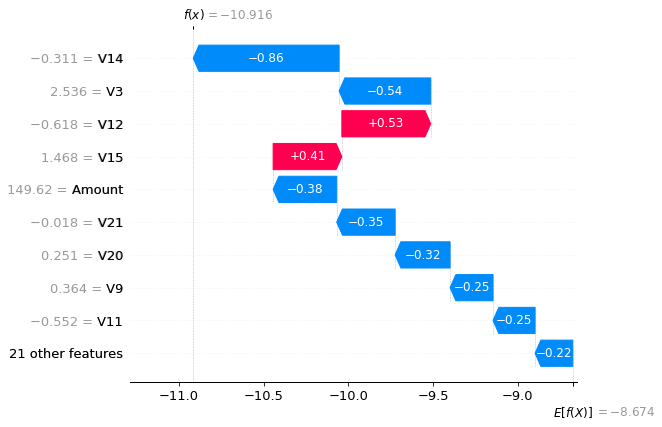

In [78]:
#individual case display
shap.waterfall_plot(shap.Explanation(values=shap_values[0], 
                                     base_values=explainer.expected_value, 
                                     data=X.iloc[0,:],
                                     feature_names=X.columns.tolist()))